In [1]:
import sys
import os
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase
from itertools import groupby
from copy import deepcopy


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
from utils.os_utils import smart_makedirs
import networkx as nx
from debruijn_graph import DeBruijnGraph, iterative_graph, get_frequent_kmers, get_all_kmers

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

# Read and correct gaps

In [11]:
lrd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
monomers_fn = '/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa'


lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [12]:
monomer_strings = {r_id: record.string for r_id, record in lrd_report.records.items()}
len(monomer_strings)

471

In [13]:
def filter_strings(monomer_strings, max_gap=0.05, max_lowercase=0.01):
    filtered_strings = {}
    for r_id, string in monomer_strings.items():
        ngaps = Counter(string)['=']
        lowercase = [s.islower() for s in string]
        if np.mean(lowercase) > max_lowercase:
            continue
        if ngaps / len(string) <= max_gap:
            filtered_strings[r_id] = string
    return filtered_strings

In [14]:
monomer_strings = filter_strings(monomer_strings)
len(monomer_strings)

407

In [15]:
def get_ma(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def trim_read(monomer_string, max_gap, ma_window):
    is_gap = [c == '=' for c in monomer_string]
    ma = get_ma(is_gap, N=ma_window)
    l = 0
    while l < len(ma) and ma[l] > max_gap:
        l += 1
    r = len(ma) - 1
    while r >= 0 and ma[r] > max_gap:
        r -= 1
    trimmed_read = monomer_string[l:r+1+ma_window]
    trimmed_read = trimmed_read.strip('=')
    return trimmed_read

def trim_reads(monomer_strings, max_gap=0.2, ma_window=30):
    trimmed_reads = {}
    for r_id, monomer_string in monomer_strings.items():
        trimmed_read = trim_read(monomer_string, max_gap=max_gap, ma_window=ma_window)
        trimmed_reads[r_id] = trimmed_read
    return trimmed_reads

In [16]:
monomer_strings = trim_reads(monomer_strings)
len(monomer_strings)

407

In [17]:
frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=3, min_mult=1000)
db = DeBruijnGraph(k=3)
db.add_kmers(frequent_kmers, coverage=frequent_kmers)

hors, _ = db.get_contigs()

def get_ngaps(strings):
    ngaps = 0
    for r_id, string in strings.items():
        r_ngaps = Counter(string)['=']
        if r_ngaps >= 5:
            mstring = string.lower()
            mstring = mstring.replace('=', '|')
            # print(r_id)
            # print(mstring)
            # print("")
        ngaps += r_ngaps
    return ngaps
ngaps = get_ngaps(monomer_strings)
print(ngaps)

def correct_gaps(monomer_strings, hors, max_gap=0.3, nhor=5):
    corrected_strings = {}
    for r_id, monomer_string in monomer_strings.items():
            corrected_string = list(monomer_string)
            for single_hor in hors:
                for i_nhor in range(1, nhor+1):
                    hor = single_hor * i_nhor
                    hor_len = len(hor)
                    for i in range(len(monomer_string)-hor_len+1):
                        kmer = monomer_string[i:i+hor_len]
                        gap_cnt = Counter(kmer)['=']
                        if gap_cnt == 0 or gap_cnt / hor_len > max_gap:
                            continue
                        hd, _ = hamming_distance(kmer, hor, match_char=set('='))
                        if hd == 0:
                            # print(hor)
                            # print(kmer)
                            # print("")
                            corrected_string[i:i+hor_len] = list(hor)
                        
            corrected_strings[r_id] = ''.join(corrected_string)
    return corrected_strings

monomer_strings = correct_gaps(monomer_strings, hors)
ngaps = get_ngaps(monomer_strings)
print(ngaps)

1704
331


In [18]:
def get_read_coverage(frequent_kmers_read_pos, monomer_strings, k):
    coverage = {}
    for r_id, string in monomer_strings.items():
        coverage[r_id] = [0] * (len(string) + 1)
    for pairs in frequent_kmers_read_pos.values():
        for r_id, pos in pairs:
            coverage[r_id][pos] += 1
            coverage[r_id][pos+k] -= 1
    for r_id in coverage:
        coverage[r_id] = np.cumsum(coverage[r_id])
        coverage[r_id] = coverage[r_id][:-1]
    return coverage

def find_zero_cov(coverage):
    all_zero_cov = {}
    for r_id in coverage:
        zero_cov_flatten = np.where(coverage[r_id] == 0)[0]
        if len(zero_cov_flatten) == 0:
            all_zero_cov[r_id] = []
            continue
        zero_cov = []
        zero_cov.append([zero_cov_flatten[0]])
        for pos in zero_cov_flatten[1:]:
            if pos == zero_cov[-1][-1] + 1:
                zero_cov[-1].append(pos)
            else:
                zero_cov.append([pos])
        
        all_zero_cov[r_id] = [(x[0], x[-1]) for x in zero_cov]
        
    return all_zero_cov

def find_path_debr(zero_cov, read_seq, r_id, k, db,
                   max_len=1000, min_len=1, min_overlap=3, max_overlap=30, max_dist=1):
    k -= 1
    results = {}
    corrected_seq = list(read_seq)
    for st, en in zero_cov[::-1]:
        if st < k or en > len(read_seq) - 1 - k or en-st+1 > max_len or en-st+1 < min_len:
            # results[(st, en)] = '-'
            continue
        # print(r_id, st, en)
        st_kmer, en_kmer = read_seq[st-k:st], read_seq[en+1:en+1+k]
        # assert st_kmer in frequent_kmers
        # assert en_kmer in frequent_kmers
        # assert read_seq[st-k+1:st+1] not in frequent_kmers
        # assert read_seq[en:en+k] not in frequent_kmers
        # assert st_kmer in db.graph.nodes

        u = st_kmer
        kmers = [u]
        while u != en_kmer and len(kmers) < 2*k:
            u_node = db.node_mapping[u]
            out_edges = list(db.graph.out_edges(u_node))
            # print(list(db.graph.nodes(data=True))[0])
            # print(u, len(db.graph.in_edges(u_node)), len(out_edges))
            # print(out_edges)
            if len(out_edges) == 1:
                edge = out_edges[0]
                assert edge[0] == u_node
                u_node = edge[1]
                u = db.rev_node_mapping[u_node]
                kmers.append(u)
            else:
                break
            
        if len(kmers) < min_overlap + 1:
            # results[(st, en)] = '-'
            # print(kmers)
            continue

        # print(len(kmers))
        extension = [kmer[-1] for kmer in kmers[1:]]
        extension = ''.join(extension)
        read_segment = read_seq[en+1:en+len(extension)]
        # print(extension)
        # print(read_segment)
        
        ident = identity_shift(extension[:max_overlap],
                               read_segment[:max_overlap],
                               min_overlap=min_overlap,
                               match_char=set('='))
        # print(ident)
        if ident['id'] == 1 and ident['shift'] is not None:
            # print(ident)
            correction = extension[:ident['shift']]
            if abs(len(correction) - (en-st+1)) > 10:
                # results[(st, en)] = '-'
                continue
            print(read_seq[st:en+1], read_seq[st-5:en+6])
            print(correction, len(correction))
            print("")
            results[(st, en)] = (read_seq[st:en+1], correction)
            corrected_seq[st:en+1] = list(correction)
    corrected_seq = ''.join(corrected_seq)
    return results, corrected_seq


def correct_seq(monomer_strings, k, min_mult=10):
    frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=k, min_mult=min_mult)
    db = DeBruijnGraph(k=k)
    db.add_kmers(frequent_kmers, coverage=frequent_kmers)
    coverage = get_read_coverage(frequent_kmers_read_pos=frequent_kmers_read_pos,
                                 monomer_strings=monomer_strings,
                                 k=k)
    zero_cov = find_zero_cov(coverage=coverage)
    
    all_corrections = {}
    corrected_seqs = {}
    for r_id in zero_cov:
        all_corrections[r_id], corrected_seqs[r_id] = find_path_debr(zero_cov[r_id],
                                                              monomer_strings[r_id],
                                                              r_id=r_id,
                                                              k=k,
                                                              db=db)
    return all_corrections, corrected_seqs


def correct_reads(monomer_strings, min_k=10, max_k=200, niter=1):
    corrected_seqs = monomer_strings
    for k in range(min_k, max_k):
        for i in range(niter):
            print(k, i)
            all_corrections, corrected_seqs = correct_seq(corrected_seqs, k=k)
            for r_id, corrections in all_corrections.items():
                if len(corrections):
                    print(r_id, corrections)
    return corrected_seqs

In [13]:
monomer_strings = correct_reads(monomer_strings)

10 0
== DEFGH==LMNOP
IJK 3

= NOPQL=NOPQR
M 1

B EFGHIBKLMNO
J 1

= BCGHI=KLMNO
J 1

== ADEFG==JKLMN
HI 2

= ADEFG=IJKLM
H 1

F BFGHIFKLMNO
J 1

C FGHIJCLMNOP
K 1

EFG= RABCGEFG=IJKLM
H 1

= QRADE=GHIJK
F 1

343a21b5-fd1f-486f-bf0f-5d4cabcda6e9 {(620, 621): ('==', 'IJK')}
42da64e4-e647-4426-b497-cda32cd3ca28 {(301, 301): ('=', 'M')}
46a4165e-6315-4339-9d4e-3af1ca00b3fc {(902, 902): ('B', 'J')}
647c3a75-dc83-414f-b342-6df41c7e59b7 {(398, 398): ('=', 'J')}
8e85dd90-8045-4df1-ba7b-b6b576deaa4d {(408, 409): ('==', 'HI')}
9e50bfee-7cce-4e72-9557-e40959c5fc51 {(29, 29): ('=', 'H')}
9ec8cb0b-c287-4823-9612-96befabdab60 {(84, 84): ('F', 'J')}
c210d178-68e0-4389-ad0a-5009d96c9d9c {(598, 598): ('C', 'K')}
c7e3bd82-2f61-4662-b255-ca9b66e20b95 {(130, 133): ('EFG=', 'H')}
f9474aed-548b-482b-a569-95d17bea44ba {(162, 162): ('=', 'F')}
10 1
11 0
11 1
12 0
=== DEFGH===MNOPQ
IJKL 4

= GHIJK=MNOPQ
L 1

= FGHIJ=MNOPQ
KL 2

H HIJKLHNOPQR
M 1

1d0706f6-cc39-4a05-a4fd-2ee7e1674457 {(452, 454): ('===', 'IJKL'

277 1
278 0
278 1
279 0
279 1
280 0
280 1
281 0
281 1
282 0
282 1
283 0
283 1
284 0
284 1
285 0
285 1
286 0
286 1
287 0
287 1
288 0
288 1
289 0
289 1
290 0
290 1
291 0
291 1
292 0
292 1
293 0
293 1
294 0
AB QRABCABFGHIJ
DE 2

ab3606e5-0041-4da0-9db5-6a30aedd8b83 {(603, 604): ('AB', 'DE')}
294 1
295 0
295 1
296 0
296 1
297 0
D QRABCDHIJKL
G 1

03e1fc3d-8e77-4170-94e1-3711db044f8b {(331, 331): ('D', 'G')}
297 1
298 0
298 1
299 0
299 1


In [14]:
ngaps = get_ngaps(monomer_strings)
print(ngaps)

104


# Iterative construction

In [19]:
min_k, max_k = 10, 650
contigs, dbs = iterative_graph(monomer_strings, min_k=min_k, max_k=max_k,
                               outdir='/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191114/db_wi_error_corr')


k=10
#frequent kmers = 98

k=11
#frequent kmers = 106

k=12
#frequent kmers = 114

k=13
#frequent kmers = 122

k=14
#frequent kmers = 131

k=15
#frequent kmers = 141

k=16
#frequent kmers = 152

k=17
#frequent kmers = 164

k=18
#frequent kmers = 179

k=19
#frequent kmers = 195

k=20
#frequent kmers = 211

k=21
#frequent kmers = 227

k=22
#frequent kmers = 243

k=23
#frequent kmers = 259

k=24
#frequent kmers = 275

k=25
#frequent kmers = 291

k=26
#frequent kmers = 307

k=27
#frequent kmers = 323

k=28
#frequent kmers = 340

k=29
#frequent kmers = 357

k=30
#frequent kmers = 374

k=31
#frequent kmers = 391

k=32
#frequent kmers = 409

k=33
#frequent kmers = 427

k=34
#frequent kmers = 446

k=35
#frequent kmers = 466

k=36
#frequent kmers = 487

k=37
#frequent kmers = 508

k=38
#frequent kmers = 529

k=39
#frequent kmers = 550

k=40
#frequent kmers = 570

k=41
#frequent kmers = 590

k=42
#frequent kmers = 610

k=43
#frequent kmers = 630

k=44
#frequent kmers = 649

k=45
#frequent kmers

#frequent kmers = 13345

k=269
#frequent kmers = 13370

k=270
#frequent kmers = 13395

k=271
#frequent kmers = 13420

k=272
#frequent kmers = 13445

k=273
#frequent kmers = 13470

k=274
#frequent kmers = 13495

k=275
#frequent kmers = 13520

k=276
#frequent kmers = 13545

k=277
#frequent kmers = 13570

k=278
#frequent kmers = 13593

k=279
#frequent kmers = 13616

k=280
#frequent kmers = 13639

k=281
#frequent kmers = 13662

k=282
#frequent kmers = 13685

k=283
#frequent kmers = 13708

k=284
#frequent kmers = 13730

k=285
#frequent kmers = 13751

k=286
#frequent kmers = 13772

k=287
#frequent kmers = 13794

k=288
#frequent kmers = 13816

k=289
#frequent kmers = 13838

k=290
#frequent kmers = 13860

k=291
#frequent kmers = 13882

k=292
#frequent kmers = 13904

k=293
#frequent kmers = 13925

k=294
#frequent kmers = 13946

k=295
#frequent kmers = 13967

k=296
#frequent kmers = 13988

k=297
#frequent kmers = 14008

k=298
#frequent kmers = 14028

k=299
#frequent kmers = 14047

k=300
#frequen


k=472
#frequent kmers = 16799

k=473
#frequent kmers = 16813

k=474
#frequent kmers = 16827

k=475
#frequent kmers = 16841

k=476
#frequent kmers = 16855

k=477
#frequent kmers = 16869

k=478
#frequent kmers = 16883

k=479
#frequent kmers = 16896

k=480
#frequent kmers = 16909

k=481
#frequent kmers = 16922

k=482
#frequent kmers = 16935

k=483
#frequent kmers = 16948

k=484
#frequent kmers = 16961

k=485
#frequent kmers = 16974

k=486
#frequent kmers = 16987

k=487
#frequent kmers = 17000

k=488
#frequent kmers = 17013

k=489
#frequent kmers = 17026

k=490
#frequent kmers = 17039

k=491
#frequent kmers = 17052

k=492
#frequent kmers = 17065

k=493
#frequent kmers = 17078

k=494
#frequent kmers = 17091

k=495
#frequent kmers = 17104

k=496
#frequent kmers = 17117

k=497
#frequent kmers = 17128

k=498
#frequent kmers = 17139

k=499
#frequent kmers = 17150

k=500
#frequent kmers = 17161

k=501
#frequent kmers = 17172

k=502
#frequent kmers = 17183

k=503
#frequent kmers = 17194

k=504
#

In [78]:
# After error correction i could get to max_k = 634
# min_k, max_k = 10, 634
# contigs, dbs = iterative_graph(monomer_strings, min_k=min_k, max_k=max_k)

In [20]:
# db = dbs[max(dbs.keys())]
# db = dbs[634]
# db = dbs2[500]
db = dbs[650]


assert nx.number_weakly_connected_components(db.graph) == 1

# contigs, contig_paths = db.get_contigs()

In [27]:
len(contigs)

24

In [28]:
contig_lens = sorted(len(contig) for contig in contigs)
print(contig_lens)

[594, 630, 736, 771, 958, 1053, 1068, 1104, 1116, 1266, 1266, 1281, 1422, 1468, 1770, 1869, 2265, 2283, 2367, 3117, 3249, 3552, 4322, 4340]


In [25]:
edges, coverage = db.get_edges()

In [26]:
edge_lens = sorted(len(edge) for edge in edges)
print(edge_lens)

[636, 637, 644, 658, 658, 658, 819, 934, 939, 991, 1251, 1269, 1566, 1685, 1899, 3932, 4452, 4476]


In [29]:
nx.drawing.nx_pydot.write_dot(db.graph, 'db.dot')

In [28]:
#nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(db.graph)

#nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
#                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

In [90]:
def map_reads(monomer_strings, db, db_index=None):
    if db_index is None:
        db_index = db.index_edges()
    mapping = {}
    db_edges = list(db.graph.edges(keys=True))
    for r_id, string in monomer_strings.items():
        split_strings = list(filter(lambda string: len(string), string.split('=')))
        split_lens = [0] + [len(split_string) for split_string in split_strings]
        cum_split_lens = np.cumsum(split_lens)
        read_coords = []
        for split_ind, split_string in enumerate(split_strings):
            for i in range(len(split_string)-db.k+1):
                kmer = split_string[i:i+db.k]
                if kmer in db_index[len(kmer)]:
                    read_coords.append(db_index[len(kmer)][kmer])
        
        path = [x[0] for x in read_coords]
        path = [x[0] for x in groupby(path)]
        path = [db_edges[edge_ind] for edge_ind in path]
        
        valid_path = True
        for e1, e2 in zip(path[:-1], path[1:]):
            if e1[1] != e2[0]:
                valid_path = False
                break
        if len(read_coords):
            mapping[r_id] = (read_coords[0], read_coords[-1], valid_path, path)
        else:
            mapping[r_id] = None
    return mapping

In [21]:
mappings = map_reads(monomer_strings, db)

In [22]:
print(np.mean([read_mapping is not None for read_mapping in mappings.values()]))
print(np.mean([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))
print(np.sum([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))

for r_id, read_mapping in mappings.items():
    if read_mapping is not None and read_mapping[2]:
        print(r_id, len(monomer_strings[r_id]), len(monomer_strings[r_id]) * 171,
              len(db.get_path(read_mapping[-1])), read_mapping)

0.6560196560196561
0.9101123595505618
243
00739941-c14c-40bd-9fad-fabff753795b 798 136458 1457 ((11, 190), (0, 175), True, [(3224, 7, 0), (7, 6183, 0)])
01f80610-395e-4ef8-93d0-526989b8cb53 1214 207594 2493 ((28, 771), (28, 1480), True, [(8962, 6647, 0)])
04b2f961-f6b4-438d-9a64-83dbd6049ffc 799 136629 1778 ((27, 662), (27, 961), True, [(8962, 13888, 0)])
0540aa3e-f34b-4e74-a5e5-884b69594a0d 641 109611 1778 ((27, 306), (27, 447), True, [(8962, 13888, 0)])
05a4fa6a-38b1-40d6-916e-886ad1fb050b 1032 176472 3331 ((7, 1225), (1, 181), True, [(2222, 915, 0), (915, 8627, 0)])
05c5a912-42ad-4a57-ae81-0a318dc8c6b7 865 147915 2031 ((1, 733), (1, 803), True, [(915, 8627, 0)])
079aa8c8-90a4-4fe8-af37-d9170f7d82b7 983 168093 2493 ((28, 265), (28, 742), True, [(8962, 6647, 0)])
08a68948-5d96-4ed2-9632-c86d0200d914 1071 183141 1255 ((20, 8), (5, 307), True, [(7678, 1652, 0), (1652, 1839, 0), (1839, 1913, 0), (1913, 11129, 0)])
0aca72fc-0a1e-416a-beb5-6b4bde55eb81 778 133038 1799 ((7, 0), (7, 213), Tr

In [34]:
def filter_mappings(mappings, db):
    filtered_mappings = {}
    contigs, contig_paths = db.get_contigs()
    for r_id, read_mapping in mappings.items():
        if read_mapping is None or not read_mapping[-2]:
            continue
        read_mapping = read_mapping[-1]
        rm_len = len(read_mapping)
        if rm_len == 1:
            continue
        in_contig = False
        for path in contig_paths:
            path = list(path)
            for i in range(len(path)-rm_len+1):
                subpath = path[i:i+rm_len]
                # print(subpath)
                # print(read_mapping)
                if subpath == read_mapping:
                    in_contig = True
                    break
            if in_contig:
                break
        if not in_contig:
            filtered_mappings[r_id] = read_mapping
            # print(r_id, read_mapping)
        else:
            pass
            # print(r_id, read_mapping)
    return filtered_mappings

In [35]:
scaffolding_reads = filter_mappings(mappings, db)

In [36]:
len(scaffolding_reads)

31

In [37]:
def get_scaffold_links(scaffolding_reads, db):
    scaffolds = defaultdict(list)
    contigs, contig_paths = db.get_contigs()
    for r_id, scaffolding_read in scaffolding_reads.items():
        best_lo, best_lo_len, best_lo_shift = None, 0, 0
        best_ro, best_ro_len, best_ro_shift = None, 0, 0
        
        for i, path in enumerate(contig_paths):
            l_overlap = identity_shift(path, scaffolding_read, min_overlap=1)
            r_overlap = identity_shift(scaffolding_read, path, min_overlap=1)
            if l_overlap['id'] == 1 and len(l_overlap['alt_shifts']) == 0 \
                    and l_overlap['len'] >= best_lo_len \
                    and l_overlap['shift'] + len(scaffolding_read) > len(path) \
                    and l_overlap['shift'] >= 1:
                best_lo = list(path)
                best_lo_len = l_overlap['len']
                best_lo_shift = l_overlap['shift']
            
            if r_overlap['id'] == 1 and len(r_overlap['alt_shifts']) == 0 \
                    and r_overlap['len'] >= best_ro_len \
                    and r_overlap['shift'] + len(path) > len(scaffolding_read) \
                    and r_overlap['shift'] >= 1:
                best_ro = list(path)
                best_ro_len = r_overlap['len']
                best_ro_shift = r_overlap['shift']
            
        if best_lo is not None and best_ro is not None:
            scaffold = best_lo[:best_lo_shift] + scaffolding_read[:best_ro_shift] + best_ro
            scaffold = tuple(scaffold)
            scaffolds[scaffold].append(r_id)
#             print('left')
#             print(r_id)
#             print('read', scaffolding_read)
#             print('contig', best_lo)
#             print("")
#             print('right')
#             print(r_id)
#             print('read', scaffolding_read)
#             print('contig', best_ro)
#             print("")
#             print("scaffold:", scaffold)
#             print(len(db.get_path(scaffold)))
#             print("")
    
    return scaffolds
            

In [38]:
scaffolds = get_scaffold_links(scaffolding_reads, db)

In [41]:
for scaffold in scaffolds:
    print(scaffold, len(db.get_path(scaffold)))

((10200, 6486, 0), (6486, 6792, 0), (6792, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 0)) 6008
((6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 0), (9036, 4263, 0), (4263, 2694, 0)) 9667
((6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 1), (9036, 4263, 0), (4263, 2694, 0)) 9649


# Investigation of 303-304

In [66]:
db465 = dbs[465]
db466 = dbs[466]

In [73]:
db465.graph.edges[3736, 7, 0]['edge_kmer']

'DEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQ'

In [74]:
db466.graph.edges[3721, 7, 0]['edge_kmer']

'CDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQR'

In [87]:
db466.graph.edges[3724, 3721, 0]['edge_kmer'][-465:]

'CDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQ'

In [88]:
db466.graph.edges[6918, 7080, 0]['edge_kmer'][-465:]

'ADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQ'

# "Complex" vertices

In [21]:
db = dbs[650]
nx.number_weakly_connected_components(db.graph)

1

In [22]:
def get_complex_nodes(graph):
    complex_nodes = []
    for node in graph.nodes():
        indegree, outdegree = graph.in_degree(node), graph.out_degree(node)
        if indegree > 1 and outdegree > 1:
            complex_nodes.append(node)
    return complex_nodes

In [23]:
get_complex_nodes(db.graph)

[]

In [24]:
def get_paths_thru_complex_nodes(db, strings):
    complex_nodes = get_complex_nodes(db.graph)
    k = db.k
    all_kp1mers, _ = get_all_kmers(strings, k=k+1)
    selected_kp1mers = []
    for node in complex_nodes:
        for in_edge in db.graph.in_edges(node, keys=True, data=True):
            for out_edge in db.graph.out_edges(node, keys=True, data=True):
                in_kmer = in_edge[3]['edge_kmer'][-k:]
                out_kmer = out_edge[3]['edge_kmer'][:k]
                assert in_kmer[1:] == out_kmer[:-1]
                kp1 = in_kmer + out_kmer[-1]
                print(in_edge[:3], out_edge[:3], all_kp1mers[kp1])
                if all_kp1mers[kp1]:
                    selected_kp1mers.append(kp1)
    return selected_kp1mers

In [25]:
get_paths_thru_complex_nodes(db, monomer_strings)

[]

In [84]:
dbs

{10: <debruijn_graph.DeBruijnGraph at 0x7f1325cb1940>,
 11: <debruijn_graph.DeBruijnGraph at 0x7f1402995fd0>,
 12: <debruijn_graph.DeBruijnGraph at 0x7f13ef5fbef0>,
 13: <debruijn_graph.DeBruijnGraph at 0x7f13ef5fbcf8>,
 14: <debruijn_graph.DeBruijnGraph at 0x7f1324ddb390>,
 15: <debruijn_graph.DeBruijnGraph at 0x7f140298fe80>,
 16: <debruijn_graph.DeBruijnGraph at 0x7f13ef5fbf60>,
 17: <debruijn_graph.DeBruijnGraph at 0x7f13efedea20>,
 18: <debruijn_graph.DeBruijnGraph at 0x7f1324e6d5c0>,
 19: <debruijn_graph.DeBruijnGraph at 0x7f1326d36fd0>,
 20: <debruijn_graph.DeBruijnGraph at 0x7f132dcad1d0>,
 21: <debruijn_graph.DeBruijnGraph at 0x7f13ee53cc88>,
 22: <debruijn_graph.DeBruijnGraph at 0x7f13250604e0>,
 23: <debruijn_graph.DeBruijnGraph at 0x7f1303999cc0>,
 24: <debruijn_graph.DeBruijnGraph at 0x7f1301207e48>,
 25: <debruijn_graph.DeBruijnGraph at 0x7f13ece7a0b8>,
 26: <debruijn_graph.DeBruijnGraph at 0x7f13ece6f400>,
 27: <debruijn_graph.DeBruijnGraph at 0x7f132b8f8e10>,
 28: <debr

# Manual scaffolding of long edges in graph with k=650

In [26]:
from string import ascii_uppercase

man_assembly_fn = "/Poppy/abzikadze/centroFlye/centroFlye_repo/data/D6Z1/CEN6_ManVERSION3.tsv"

units = []
with open(man_assembly_fn) as f:
    for line in f:
        line = line.strip().split('\t')
        st, en = int(line[-2]), int(line[-1])
        if en < 17:
            en -= 1
        units.append((st, en))

def units2monomers(units):
    monomers = []
    for (s, e) in units:
        monomers.append(ascii_uppercase[s:e+1])
    monomers = ''.join(monomers)
    return monomers

ref_monomers = units2monomers(units)

def get_cov(ref_monomers, seqs, max_ed=10000):
    coverage = [0] * (len(ref_monomers)+1)
    for r_id, seq in seqs.items():
        alignment = edlib.align(seq,
                                ref_monomers,
                                mode='HW',
                                task='locations',
                                k=max_ed)
        print(r_id, alignment, np.diff(alignment['locations']))
        loc = alignment['locations']
        if loc is None or len(loc) != 1:
            continue
        else:
            loc = loc[0]
        coverage[loc[0]] += 1
        coverage[loc[1]+1] -= 1
    coverage = np.cumsum(coverage)
    return coverage

In [44]:
db = dbs[400]

In [57]:
def get_long_edges(db, min_len=1000, max_cov=25):
    edges = {}
    for edge in db.graph.edges(data=True, keys=True):
        edge_len = len(edge[-1]['edge_kmer'])
        edge_cov = np.min(edge[-1]['coverages'])
        if edge_len >= min_len and edge_cov <= max_cov:
            print(edge_len, np.median(edge_cov))
            edges[edge[:-1]] = edge[-1]['edge_kmer']
    return edges

In [58]:
long_edges = get_long_edges(db)

1260 18.0
1442 25.0
1203 12.0
1931 16.0
2426 24.0
1530 16.0
1239 14.0
1890 12.0
1581 10.0


(7, 9915, 0) {'editDistance': 2, 'alphabetLength': 18, 'locations': [(489, 1750)], 'cigar': None} [[1261]]
(942, 7050, 0) {'editDistance': 27, 'alphabetLength': 18, 'locations': [(5781, 7221)], 'cigar': None} [[1440]]
(2466, 5451, 0) {'editDistance': 1, 'alphabetLength': 18, 'locations': [(13962, 15165)], 'cigar': None} [[1203]]
(2929, 2239, 0) {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8307, 10237)], 'cigar': None} [[1930]]
(4445, 10624, 0) {'editDistance': 6, 'alphabetLength': 18, 'locations': [(3132, 5554)], 'cigar': None} [[2422]]
(5120, 5451, 0) {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1889, 3419)], 'cigar': None} [[1530]]
(5120, 11585, 0) {'editDistance': 0, 'alphabetLength': 18, 'locations': [(7066, 8304)], 'cigar': None} [[1238]]
(5509, 11189, 0) {'editDistance': 3, 'alphabetLength': 18, 'locations': [(14899, 16790)], 'cigar': None} [[1891]]
(11189, 7050, 0) {'editDistance': 63, 'alphabetLength': 18, 'locations': [(1469, 3089), (1469, 3090), (1469,

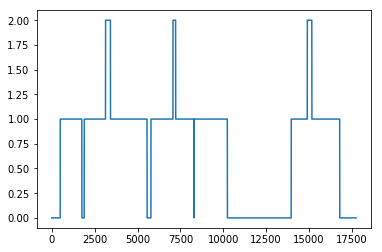

In [59]:
cov = get_cov(ref_monomers, long_edges)
plt.plot(cov)

In [60]:
long_reads = {k: v for k, v in monomer_strings.items() if len(v) >= 1000}
len(long_reads)

108

01f80610-395e-4ef8-93d0-526989b8cb53 {'editDistance': 8, 'alphabetLength': 19, 'locations': [(3836, 5046)], 'cigar': None} [[1210]]
05a4fa6a-38b1-40d6-916e-886ad1fb050b {'editDistance': 1, 'alphabetLength': 18, 'locations': [(7955, 8987)], 'cigar': None} [[1032]]
08a68948-5d96-4ed2-9632-c86d0200d914 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(9967, 11037)], 'cigar': None} [[1070]]
0c50866b-f780-4551-a4bb-aa35a72f3f4d {'editDistance': 5, 'alphabetLength': 19, 'locations': [(1428, 2775)], 'cigar': None} [[1347]]
0c849de1-fbde-4ff4-bf9e-a7675a011e11 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8408, 9437)], 'cigar': None} [[1029]]
11416399-75e7-4251-824f-c17721a01605 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1745, 3131)], 'cigar': None} [[1386]]
13b093b1-6dd5-4fbe-9a41-0c927ef131ff {'editDistance': 1, 'alphabetLength': 18, 'locations': [(8957, 10358)], 'cigar': None} [[1401]]
14eb3993-37ae-468e-9e48-c2eeeb996ed3 {'editDistance': 1, 'alphabetLength':

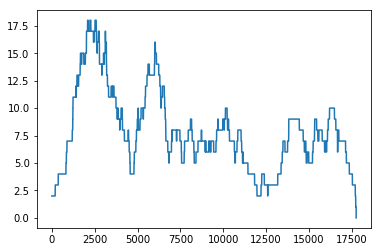

In [61]:
cov = get_cov(ref_monomers, long_reads)
plt.plot(cov)

In [65]:
def connect_edges(edges, reads, min_overlap=300, min_id=0.97):
    connections = defaultdict(list)
    for r_id, read in reads.items():
        b_pref_al, b_pref_overlap, b_pref_edge = None, 0, None
        b_suf_al, b_suf_overlap, b_suf_edge = None, 0, None
        
        # print("\n!!!!!\n")
        for e_id, edge in edges.items():
            er = identity_shift(edge, read, min_overlap, match_char=set('=?'))
            re = identity_shift(read, edge, min_overlap, match_char=set('=?'))
            if er['shift'] != None and len(er['alt_shifts']) == 0 and er['id'] > min_id \
                    and er['len'] > b_pref_overlap:
                b_pref_al = er
                b_pref_overlap = b_pref_overlap
                b_pref_edge = e_id
            
            if re['shift'] != None and len(re['alt_shifts']) == 0 and re['id'] > min_id \
                    and re['len'] > b_suf_overlap:
                b_suf_al = re
                b_suf_overlap = b_suf_overlap
                b_suf_edge = e_id
        
        if b_suf_edge is not None and b_pref_edge is not None and b_suf_edge != b_pref_edge:
            print(r_id)
            print(b_pref_edge, b_pref_al)
            print(b_suf_edge, b_suf_al)
            dist = len(read) - b_pref_al['len'] - b_suf_al['len']
            print(dist)
            connections[(b_pref_edge, b_suf_edge)].append((r_id, dist))
    return connections

In [68]:
connections = connect_edges(long_edges, monomer_strings)

00739941-c14c-40bd-9fad-fabff753795b
(5120, 5451, 0) {'id': 1.0, 'shift': 1227, 'hd': 0, 'len': 303, 'alt_shifts': []}
(7, 9915, 0) {'id': 1.0, 'shift': 7, 'hd': 0, 'len': 791, 'alt_shifts': []}
-296
054f1983-9204-4889-936a-64ab45e7810c
(2929, 2239, 0) {'id': 1.0, 'shift': 1341, 'hd': 0, 'len': 590, 'alt_shifts': []}
(11189, 7050, 0) {'id': 0.9970238095238095, 'shift': 365, 'hd': 1, 'len': 336, 'alt_shifts': []}
-225
057047e6-eb15-4d39-b4f6-473ecba0558a
(5120, 5451, 0) {'id': 1.0, 'shift': 1229, 'hd': 0, 'len': 301, 'alt_shifts': []}
(2466, 5451, 0) {'id': 1.0, 'shift': 115, 'hd': 0, 'len': 510, 'alt_shifts': []}
-186
05a4fa6a-38b1-40d6-916e-886ad1fb050b
(5120, 11585, 0) {'id': 1.0, 'shift': 889, 'hd': 0, 'len': 350, 'alt_shifts': []}
(2929, 2239, 0) {'id': 1.0, 'shift': 351, 'hd': 0, 'len': 681, 'alt_shifts': []}
1
0aca72fc-0a1e-416a-beb5-6b4bde55eb81
(11189, 7050, 0) {'id': 1.0, 'shift': 1246, 'hd': 0, 'len': 335, 'alt_shifts': []}
(5120, 11585, 0) {'id': 1.0, 'shift': 125, 'hd': 0, 

83a800ae-fe30-456c-b2d4-63aea374b2f1
(942, 7050, 0) {'id': 1.0, 'shift': 553, 'hd': 0, 'len': 889, 'alt_shifts': []}
(5120, 11585, 0) {'id': 1.0, 'shift': 679, 'hd': 0, 'len': 500, 'alt_shifts': []}
-210
86fdd7a8-71b5-46fa-90d2-5e6888ae2289
(942, 7050, 0) {'id': 1.0, 'shift': 1011, 'hd': 0, 'len': 431, 'alt_shifts': []}
(5120, 11585, 0) {'id': 1.0, 'shift': 221, 'hd': 0, 'len': 1086, 'alt_shifts': []}
-210
96779c5c-4eee-4184-ae1c-182e6b5ccb6a
(5120, 5451, 0) {'id': 1.0, 'shift': 716, 'hd': 0, 'len': 814, 'alt_shifts': []}
(11189, 7050, 0) {'id': 0.9969418960244648, 'shift': 556, 'hd': 1, 'len': 327, 'alt_shifts': []}
-258
97d968c4-3f16-4c6e-acb2-f79f092e9ab3
(942, 7050, 0) {'id': 1.0, 'shift': 623, 'hd': 0, 'len': 819, 'alt_shifts': []}
(5120, 11585, 0) {'id': 1.0, 'shift': 609, 'hd': 0, 'len': 405, 'alt_shifts': []}
-210
985d441d-f732-4ac6-8a9e-a9433dfc6fd1
(5509, 11189, 0) {'id': 1.0, 'shift': 1309, 'hd': 0, 'len': 581, 'alt_shifts': []}
(11189, 7050, 0) {'id': 1.0, 'shift': 182, 'hd

(7, 9915, 0) {'editDistance': 2, 'alphabetLength': 18, 'locations': [(489, 1750)], 'cigar': None} [[1261]]
(942, 7050, 0) {'editDistance': 27, 'alphabetLength': 18, 'locations': [(5781, 7221)], 'cigar': None} [[1440]]
(2466, 5451, 0) {'editDistance': 1, 'alphabetLength': 18, 'locations': [(13962, 15165)], 'cigar': None} [[1203]]
(2929, 2239, 0) {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8307, 10237)], 'cigar': None} [[1930]]
(4445, 10624, 0) {'editDistance': 6, 'alphabetLength': 18, 'locations': [(3132, 5554)], 'cigar': None} [[2422]]
(5120, 5451, 0) {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1889, 3419)], 'cigar': None} [[1530]]
(5120, 11585, 0) {'editDistance': 0, 'alphabetLength': 18, 'locations': [(7066, 8304)], 'cigar': None} [[1238]]
(5509, 11189, 0) {'editDistance': 3, 'alphabetLength': 18, 'locations': [(14899, 16790)], 'cigar': None} [[1891]]
(11189, 7050, 0) {'editDistance': 63, 'alphabetLength': 18, 'locations': [(1469, 3089), (1469, 3090), (1469,

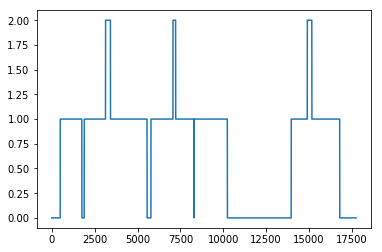

In [64]:
cov = get_cov(ref_monomers, long_edges)
plt.plot(cov)

In [74]:
for edge_pair, read_list in connections.items():
    dist_cnt = Counter(x[1] for x in read_list)
    mc = dist_cnt.most_common(1)
    if mc[0][1] >= 2:
        print(edge_pair)
        for r_id, dist in read_list:
            print(r_id, dist)
        print("")

((5120, 11585, 0), (2929, 2239, 0))
05a4fa6a-38b1-40d6-916e-886ad1fb050b 1
2150aca2-413b-4207-ab2d-ac2f390a625d 1
814fadd3-b302-42f2-b650-d53315b7844e 1
a61180df-982c-4d59-b8b3-eedad055ac2e 1
e7f9d7d2-9144-4693-b36e-e5c7e1fce608 1

((11189, 7050, 0), (5120, 11585, 0))
0aca72fc-0a1e-416a-beb5-6b4bde55eb81 -210
7c28cc24-1d36-456f-a02c-bef0849fbf2a -210

((2466, 5451, 0), (5509, 11189, 0))
0b1f944b-90f7-4e17-a1cd-f02d38d0f84c -267
a5bfccd4-6695-42aa-aba2-6d4b2ca248b4 -267

((7, 9915, 0), (5120, 5451, 0))
0c50866b-f780-4551-a4bb-aa35a72f3f4d 136
1b4bd09e-07f3-4455-b041-c4599b6fbe3d 138
2fef785e-910e-4071-87f5-ba59052d4f7f 138
35aded7d-a60e-4628-ab38-4fd91010c0f6 138
6386eb83-821a-4093-8119-cec9ed1214dd 84
76b12196-6464-428c-97e7-f75f1c263d5e 138
ca06626a-da2b-4f24-afd0-1696dede7a5d -132

((942, 7050, 0), (5120, 11585, 0))
10b78685-fe40-49f4-bb76-848371912dea -210
83a800ae-fe30-456c-b2d4-63aea374b2f1 -210
86fdd7a8-71b5-46fa-90d2-5e6888ae2289 -210
97d968c4-3f16-4c6e-acb2-f79f092e9ab3 -210
ea